In [1]:
from typing import List
import re
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

2022-09-09 18:07:16.265483: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-09 18:07:16.265513: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_csv("SPAM text message 20170820 - Data.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [4]:
df.dtypes

Category    object
Message     object
dtype: object

In [5]:
df.shape

(5572, 2)

In [6]:
df.isnull().sum()

Category    0
Message     0
dtype: int64

In [7]:
df.rename(columns={'Category': 'label', 'Message': 'message'}, inplace=True)

In [8]:
pie_df = df.groupby('label').count()

In [9]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

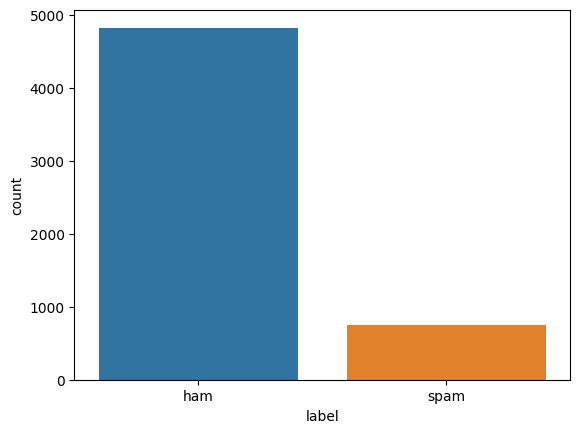

In [10]:
sns.countplot(df['label'])

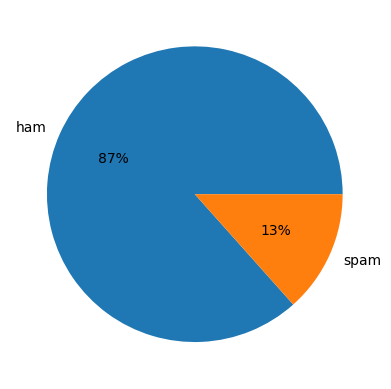

In [11]:
data = pie_df['message'].tolist()
keys = ["ham", "spam"]
plt.pie(data, labels=keys, autopct='%.0f%%')
plt.show()

In [12]:
df.groupby('label').count()

,message
label,
ham,4825
spam,747


In [13]:
X = df.drop('label', axis=1)

In [14]:
df['label'] = df['label'].apply(lambda data: np.where(data == "ham", 1, 0))

In [15]:
y = df['label']

In [16]:
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [17]:
lemmatizer = WordNetLemmatizer()

In [18]:
corpus = []
def preprocessing(dataframe)-> List:
    """
    Processes dataframe having one text column.
    
    Args:
        dataframe (Dataframe):
            The dataframe where the single text column exists.
    Returns:
        list:
            The list of the processed sentences.
    """
    for i in range(0, len(dataframe)):
        review = re.sub('[^a-zA-Z0-9]', ' ', dataframe['message'][i])
        review = review.lower()
        review = review.split()
        review = [lemmatizer.lemmatize(word) for word in review if not word in stopwords.words('english')]
        review = ' '.join(review)
        corpus.append(review)
    # return corpus

In [19]:
preprocessing(dataframe=X)

In [20]:
voc_size = 10000
onehot_repr=[tf.keras.preprocessing.text.one_hot(words,voc_size)for words in corpus] 

In [21]:
max_sentence_length = max([len(each_list) for each_list in onehot_repr])
print(max_sentence_length)

78


In [22]:
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=max_sentence_length)
# print(embedded_docs)

In [23]:
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [25]:
lr = LogisticRegression(max_iter=50)

In [26]:
lr.fit(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=50)

In [27]:
y_pred=lr.predict(X_test)

In [28]:
y_pred=np.where(y_pred > 0.6, 1, 0)

In [29]:
confusion_matrix(y_test,y_pred)

array([[ 102,  144],
       [  70, 1523]])

In [30]:
accuracy_list = []
logistic_regr_accuracy = accuracy_score(y_test,y_pred)
accuracy_list.append(logistic_regr_accuracy)

In [31]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.59      0.41      0.49       246
           1       0.91      0.96      0.93      1593

    accuracy                           0.88      1839
   macro avg       0.75      0.69      0.71      1839
weighted avg       0.87      0.88      0.87      1839



In [32]:
## Creating model
embedding_vector_features=300 ##features representation
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=max_sentence_length))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

2022-09-09 18:07:27.843024: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-09 18:07:27.843053: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-09 18:07:27.843075: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9f608c13c913): /proc/driver/nvidia/version does not exist
2022-09-09 18:07:27.843328: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 78, 300)           3000000   
                                                                 
 dropout (Dropout)           (None, 78, 300)           0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 3,160,501
Trainable params: 3,160,501
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
### Training
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, mode="min")
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100, callbacks=[callback])

Epoch 1/100
117/117 [==============================] - 8s 58ms/step - loss: 0.1675 - accuracy: 0.9440 - val_loss: 0.0514 - val_accuracy: 0.9859
Epoch 2/100
117/117 [==============================] - 7s 56ms/step - loss: 0.0254 - accuracy: 0.9941 - val_loss: 0.0707 - val_accuracy: 0.9826
Epoch 3/100
117/117 [==============================] - 7s 56ms/step - loss: 0.0103 - accuracy: 0.9979 - val_loss: 0.0456 - val_accuracy: 0.9875
Epoch 4/100
117/117 [==============================] - 6s 55ms/step - loss: 0.0050 - accuracy: 0.9992 - val_loss: 0.0457 - val_accuracy: 0.9886
Epoch 5/100
117/117 [==============================] - 7s 56ms/step - loss: 0.0032 - accuracy: 0.9995 - val_loss: 0.0538 - val_accuracy: 0.9869
Epoch 6/100
117/117 [==============================] - 6s 52ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.0558 - val_accuracy: 0.9869
Epoch 7/100
117/117 [==============================] - 6s 53ms/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 0.0615 - val_accuracy:

In [34]:
y_pred=model.predict(X_test)

58/58 [==============================] - 1s 13ms/step


In [35]:
y_pred=np.where(y_pred > 0.6, 1, 0)

In [36]:
confusion_matrix(y_test,y_pred)

array([[ 230,   16],
       [   3, 1590]])

In [37]:
lstm_accuracy = accuracy_score(y_test,y_pred)
accuracy_list.append(lstm_accuracy)

In [38]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       246
           1       0.99      1.00      0.99      1593

    accuracy                           0.99      1839
   macro avg       0.99      0.97      0.98      1839
weighted avg       0.99      0.99      0.99      1839



In [39]:
accuracy_list = [round(element * 100, 2) for element in accuracy_list]

In [40]:
accuracy_list

[88.36, 98.97]

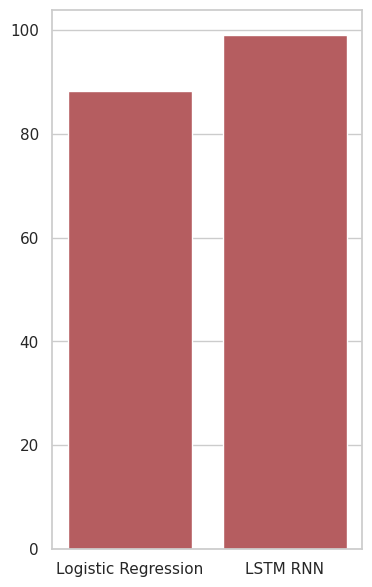

In [41]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(4, 7))
sns.set_color_codes("deep")
sns.barplot(x=["Logistic Regression", "LSTM RNN"], y=accuracy_list, color="r")
plt.show()

In [43]:
# Saving LSTM RNN model
model.save('SpamClassifier.h5')